# Test of class Hamiltonian_QED



This notebook uses the class in 'Hamiltonian_QED_oprt.py' and 'Hamiltonian_QED_sym.py' that builds the Hamiltonian in terms of Pauli matrices.


In [1]:
import qiskit

In [2]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir
from itertools import permutations

In [3]:
from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz

##### Composite circuit: gauge + fermions

In [4]:
#class input parameters:
n_sites = [2,2]#how many sites for every dimension
g=0.5
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=False
pbc=False
puregauge = False
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign
sparse_pauli=False
n_flavors = 2
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 3

In [5]:
latt = HCLattice(n_sites,pbc=pbc,n_flavors=n_flavors)

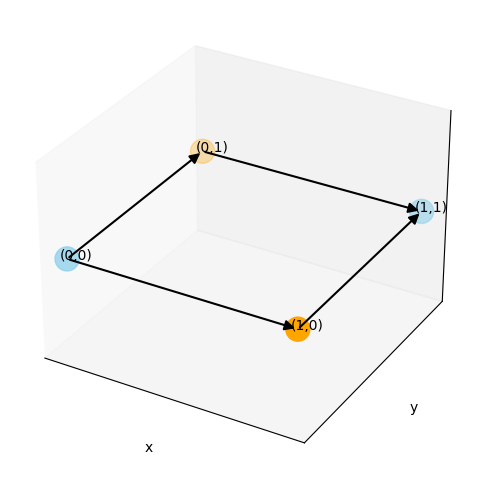

In [6]:

latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)


In [7]:
#latt.func_qstatic_dist()#ch_val=1)
#[latt.draw_graph_func(gauss_law_fig=False,static_charges=st ) for st in latt.distances_coord]#,savefig_dir='.')

In [8]:
# Creating a configuration dictionary with common inputs
config = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': None,
    'e_op_out_plus': e_op_out_plus,
    'n_flavors': n_flavors
}
hamilt_sym = HamiltonianQED_sym(config,display_hamiltonian=False)
class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym, sparse_pauli=sparse_pauli)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.011663198471069336 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
qubit order |qn...q2q1q0>: [q_01, q_11, q_21, q_31, q_30, q_20, q_10, q_00, U_10y]
Hamiltonian_el_pauli done
>> Hamiltonian built.  Execution time: 3.0137152671813965 seconds
Hamiltonian suppr fermions...
Hamiltonian suppr fermions done
>> Suppression term built.  Execution time: 0.03975391387939453 seconds
Mass term and chemical potential must be a list. Has been set to a list of length n_flavors


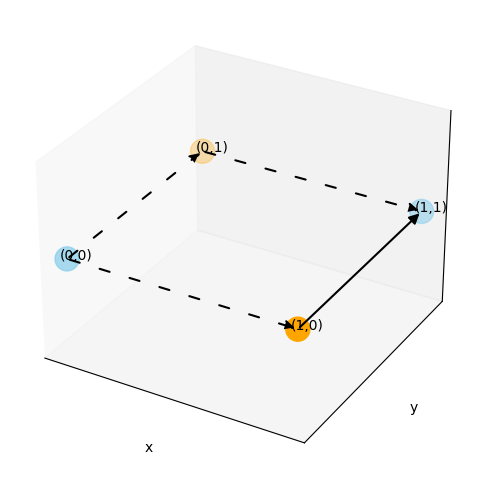

In [9]:
#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free)#,savefig_dir='.')

In [10]:
Hamiltonian_Pauli_tot_vqe = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0,chem_pot=0)


Mass term and chemical potential must be a list. Has been set to a list of length n_flavors


In [11]:
print(class_H_oprt.uop_list, class_H_oprt.qop_list)
# new list for multiple flavors

[U_10y] [q_00, q_10, q_20, q_30, q_31, q_21, q_11, q_01]


Qubit list:  ['U_10y', 'U_10y', 'q_00', 'q_10', 'q_20', 'q_30', 'q_31', 'q_21', 'q_11', 'q_01']
El:  U_10y
Ferm entang:  ['q_20', 'q_31']
Ferm entang:  ['q_30', 'q_21']
CiSWAP indices:  [[0, 4, 6], [1, 4, 6], [0, 5, 7], [1, 5, 7]]
Qubit list:  ['U_10y', 'U_10y', 'q_00', 'q_10', 'q_20', 'q_30', 'q_31', 'q_21', 'q_11', 'q_01']
El:  U_10y
Ferm entang:  ['q_20', 'q_31']
Ferm entang:  ['q_30', 'q_21']
CiSWAP indices:  [[0, 4, 6], [1, 4, 6], [0, 5, 7], [1, 5, 7]]
Total n.er of qubits: 10
Total n.er of CNOT gates (Toffoli are decomposed): 122
Total n.er of parameters: 26
CNOT depth: 58


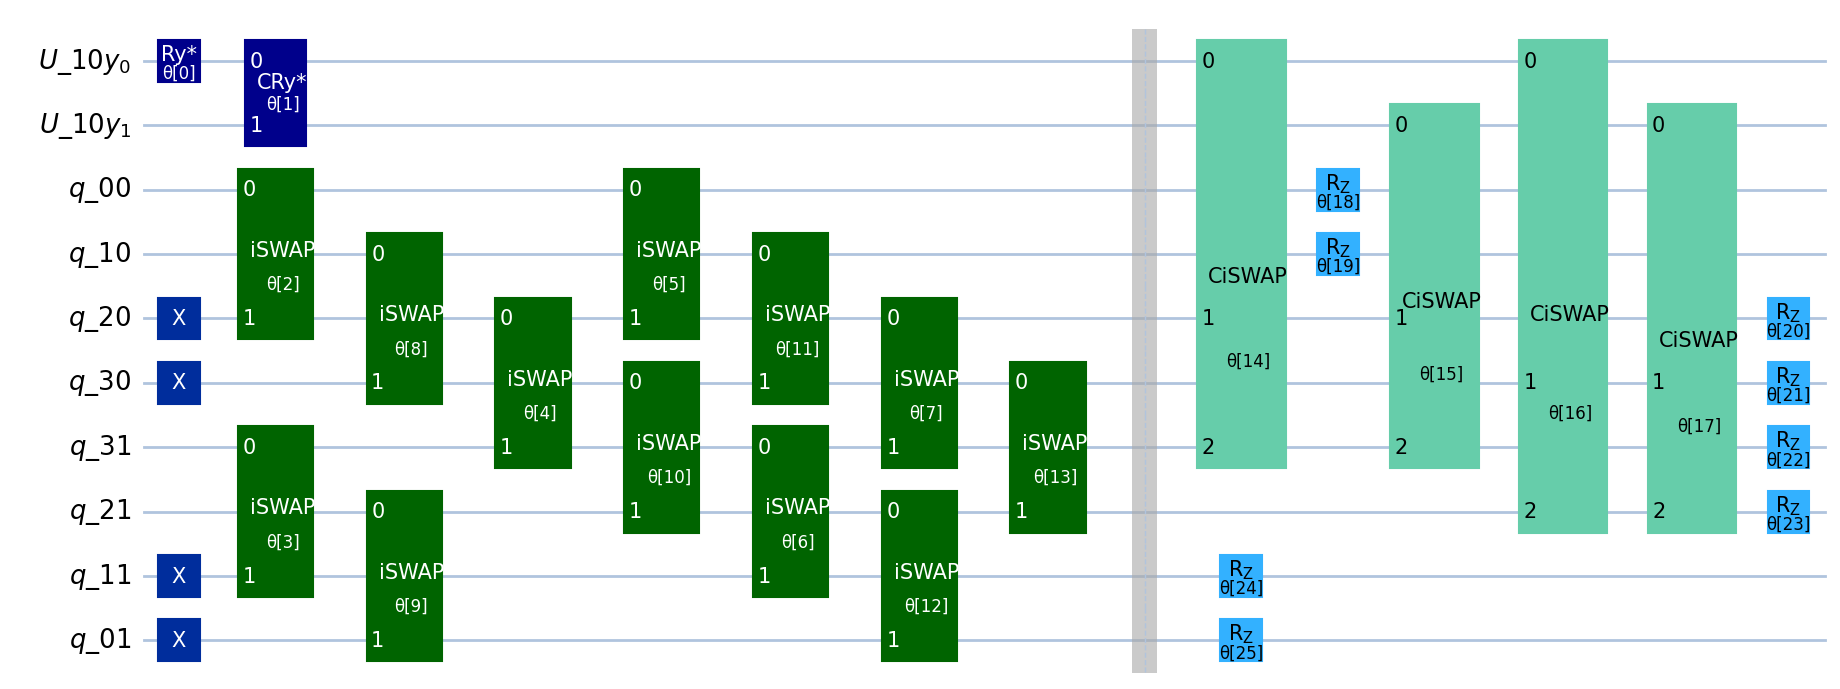

In [12]:
nlayersgauge= 1
nlayersferm=2
entanglement='full'#triangular,linear,full
rzlayer=False
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_fermions = 0
else:
    n_fermions = np.prod(latt.n_sites)

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))


ansatz_class = Ansatz(l,ngauge,nfermions=n_fermions,gauge_list= class_H_oprt.uop_list,ferm_list=class_H_oprt.qop_list, n_flavors=n_flavors)

if puregauge:
    qc_tot2,first_layer_par,thgauge = ansatz_class.puregauge_circuit_entang(entanglement=entanglement,rzlayer=rzlayer,nlayers=nlayersgauge)

else:
    qc_tot2,first_layer_par = ansatz_class.gauge_fermion_circuit(entanglement=entanglement,rzlayer=rzlayer,nlayersgauge=nlayersgauge,nlayersferm=nlayersferm)



print('Total n.er of qubits:',qc_tot2.num_qubits)
print('Total n.er of CNOT gates (Toffoli are decomposed):',dict(qc_tot2.decompose(reps=6).count_ops())['cx'])
print('Total n.er of parameters:',qc_tot2.num_parameters)
depth = qc_tot2.decompose(reps=4).depth(lambda x: x[0].num_qubits == 2)
print("CNOT depth:",depth)
#print(ansatz_class.first_layer_par)
#parameter counts
#ansatz_class.parameters_count(n_qubits,ngauge)
qc_tot2.draw('mpl',fold=-1,
             style=ansatz_class.style)